In [1]:
import os, sys, cv2, random, copy, imutils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

from formula import *

In [2]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Sequences_path = 'Sequences'
More_data_path = 'Sequences/Fluo-N2DL-HeLa-Train'

folder_list = sorted([i for i in os.listdir(Sequences_path) if len(i) == 2], key = lambda x:int(x))
ST_list = sorted([i for i in os.listdir(More_data_path) if i[-2:] == 'ST'], key = lambda x:int(x[:2])) # [01_ST, 02_ST]
print(folder_list)
print(ST_list)

['01', '02', '03', '04']
['01_ST', '02_ST']


Program Start..
Program Ends..
Program Start..
Program Ends..


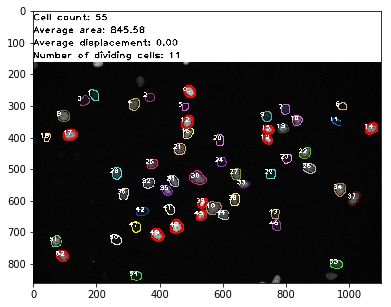

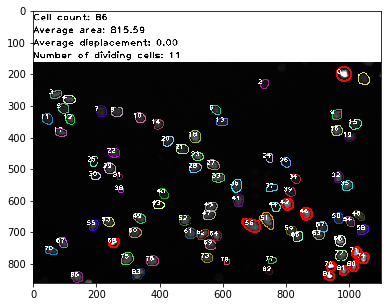

In [3]:
# Sequences_path, folder_list, no. of sequence, nth image to stop
def draw_overall_1(Sequences_path, folder_list, n, n_end): 
    # nth Sequence
    imageList = getImgPath(folder_list, Sequences_path, n)
    image, image_ero = starter_1(imageList[0])
    centreList, contours1, areas = starter_2(image, image_ero)
    '''
    warehouse = 
    {'01':{
        't001.tif':{
            '1':{'color':(X,X,X), 'centre':(X,X), 'track':[(X,X)], 'area: X', 'intensity':X, 'perimeter:'X, 'contours1':[....]
    '''
    # Creating warehouse dictionary
    warehouse = {}
    warehouse[folder_list[n]] = {}

    FirstImgName = imageList[0][-8:]
    warehouse[folder_list[n]][FirstImgName] = {}
    
    color_L = color_generator_1(contours1)
    inten_L = []
    
    # Assigning values to warehouse
    for i in range(len(color_L)):
        warehouse[folder_list[n]][FirstImgName][str(i)] = {}
        warehouse[folder_list[n]][FirstImgName][str(i)]['color'] = color_L[i]
        warehouse[folder_list[n]][FirstImgName][str(i)]['centre'] = centreList[i]
        warehouse[folder_list[n]][FirstImgName][str(i)]['track'] = [centreList[i]]
        warehouse[folder_list[n]][FirstImgName][str(i)]['contours1'] = contours1[i]
        
        cdin = get_coordinate(contours1[i])
        inten = intensity(image, cdin)
        warehouse[folder_list[n]][FirstImgName][str(i)]['intensity'] = inten
        inten_L.append(inten)
        
        warehouse[folder_list[n]][FirstImgName][str(i)]['perimeter'] = cv2.arcLength(contours1[i], True)
        
        warehouse[folder_list[n]][FirstImgName][str(i)]['area'] = areas[i]

    print('Program Start..')
    
    # Checking dividing cells
    cell_division = []
    avg_area = sum(areas) / len(areas)
    avg_inten = sum(inten_L) / len(inten_L)
    
    for i in warehouse[folder_list[n]][FirstImgName].keys():
        if warehouse[folder_list[n]][FirstImgName][i]['area'] > 2 * avg_area:
            cell_division.append(i)
        elif warehouse[folder_list[n]][FirstImgName][i]['intensity'] > 1.5 * avg_inten:
            cell_division.append(i)
    
    # Drawing the 1st image - image, contours, labels
    keys_list = [i for i in warehouse[folder_list[n]][FirstImgName].keys()]
    
    draw_1 = draw_cells(image, color_L, contours1)
    
    # Draw Thick Red Circle around dividing cells
    for i in range(len(cell_division)):
        temp = cell_division[i]
        contour = warehouse[folder_list[n]][FirstImgName][temp]['contours1']

        cv2.drawContours(draw_1, [contour], 0, (255,0,0), 6)
        
    draw_1 = labelling(keys_list, centreList, draw_1)    
    draw_1 = put_info(draw_1, avg_area, 0, len(areas), len(cell_division))
    
    plt.figure(figsize=(15, 5))
    plt.imshow(draw_1)
    
    if not os.path.exists(f'./Sequences/0{n+1}_naive/'):
        os.makedirs(f'./Sequences/0{n+1}_naive/')
    
    draw_1 = cv2.cvtColor(draw_1, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f'./Sequences/0{n+1}_naive/{FirstImgName[:-4]}.tif', draw_1)
    
    '''
    Proceed the rest images
    Classify 1. New pts, 2. Exsiting pts, 3. Vanishing pts
        1. For New pts, assign a new ID, color, centre, track, area, contour
        2. For Exsiting pts, calculate overlapping area with the last image
        3. For Vanishing pts, doing nothing
    '''
    for img_index in range(1, len(imageList[:n_end])): 
        
        image, image_ero = starter_1(imageList[img_index])
        centreList, contours1, areas = starter_2(image, image_ero)
        
        ThisImgName = imageList[img_index][-8:] # Current image name
        LastImgName = imageList[img_index - 1][-8:] # Last image name
        '''
        't001.tif':{
            '1':{'color':(X,X,X), 'centre':(X,X), 'track':[(X,X)]}, 'area: X', 'contours1':[....]
            '2':{'color':(X,X,X), 'centre':(X,X), 'track':[(X,X)]}, 'area: X', 'contours1':[....]
            ...
            'n':{'color':(X,X,X), 'centre':(X,X), 'track':[(X,X)]}, 'area: X', 'contours1':[....]
        '''
        LastImage = warehouse[folder_list[n]][LastImgName] # Info from last image
        LastCellList = list(LastImage.keys()) # All cells ID list from last image

        NewCell = []

        # Assigning values for this image
        warehouse[folder_list[n]][ThisImgName] = {}
        ThisImage = warehouse[folder_list[n]][ThisImgName]

        # Calculating overlapping area for cells
        Matched_LastCellList = []
        for ct, centre, area in zip(contours1, centreList, areas):
            Matched = False
            for ID in LastCellList:
                temp = (LastImage[ID]['contours1'], ct) # (last contours, current contours)
                olp_area = overlapping(image, temp)
                if olp_area / area_calculator(LastImage[ID]['contours1']) > 0.4: # Overlapping threshold
                    ThisImage[ID] = copy.deepcopy(LastImage[ID])
                    ThisImage[ID]['centre'] = centre
                    ThisImage[ID]['track'].append(centre)
                    ThisImage[ID]['contours1'] = ct
                    
                    cdin = get_coordinate(ct)
                    inten = intensity(image, cdin)
                    ThisImage[ID]['intensity'] = inten
                    
                    ThisImage[ID]['perimeter'] = cv2.arcLength(ct, True)
                    ThisImage[ID]['area'] = area
                    
                    Matched = True
                    Matched_LastCellList.append(ID)
                    break
            if not Matched: # New cell if not matched
                NewCell.append((ct, centre, area))

        VanishingCellName = [i for i in LastCellList if i not in Matched_LastCellList] # Vanishing Cells
        
        # Assigning values for new cells 
        for ct, centre, area in NewCell:
            LastCellID = sorted(list(ThisImage.keys()), key = lambda x:int(x))[-1] # Generate New ID from current last cells

            NewID = str(int(LastCellID) + 1)
            ThisImage[NewID] = {}

            color = color_generator_2(color_L) # Generate unique color

            ThisImage[NewID]['color'] = color
            ThisImage[NewID]['contours1'] = ct
            
            cdin = get_coordinate(ct)
            inten = intensity(image, cdin)
            ThisImage[NewID]['intensity'] = inten
            
            ThisImage[NewID]['perimeter'] = cv2.arcLength(ct, True)
            
            ThisImage[NewID]['centre'] = centre
            ThisImage[NewID]['track'] = [centre]
            ThisImage[NewID]['area'] = area

        # Reset color list & contours1
        color_L = [ThisImage[i]['color'] for i in ThisImage.keys()]
        keys_list = [i for i in ThisImage.keys()]
        centre_L = [ThisImage[i]['track'][-1] for i in ThisImage.keys()]
        track_L = [ThisImage[i]['track'] for i in ThisImage.keys()]
        contours1 = [ThisImage[i]['contours1'] for i in ThisImage.keys()]
        inten_L = [ThisImage[i]['intensity'] for i in ThisImage.keys()]
        
        # put average area, average displacement on the picture
        disp = 0
        cell_count = 0
        for i in warehouse[folder_list[n]][ThisImgName]:
            cell_count += 1
            if len(warehouse[folder_list[n]][ThisImgName][i]['track']) < 2:
                disp += 0
            else:
                center1 = np.array(warehouse[folder_list[n]][ThisImgName][i]['track'][-1])
                center2 = np.array(warehouse[folder_list[n]][ThisImgName][i]['track'][-2])
                disp += np.linalg.norm(center1 - center2)
        
        # Checking dividing cells
        cell_division = []
        
        area_L = [ThisImage[i]['area'] for i in ThisImage.keys()]
        avg_area = sum(area_L) / len(area_L)
        avg_inten = sum(inten_L) / len(inten_L)
        
        for i in ThisImage.keys():
            if ThisImage[i]['area'] > 2 * avg_area:
                cell_division.append(i)
            elif ThisImage[i]['intensity'] > 1.5 * avg_inten:
                cell_division.append(i)
            elif i in LastCellList:
                if ThisImage[i]['perimeter'] / LastImage[i]['perimeter'] > 1.2:
                    cell_division.append(i)
                    
        draw_2 = draw_cells(image, color_L, contours1)
        draw_2 = draw_lines(draw_2, track_L, color_L)
        
        # Draw Thick Red Circle around dividing cells
        for i in range(len(cell_division)):
            temp = cell_division[i]
            contour = warehouse[folder_list[n]][ThisImgName][temp]['contours1']

            cv2.drawContours(draw_2, [contour], 0, (255,0,0), 6)
            
        draw_2 = labelling(keys_list, centre_L, draw_2)
        draw_2 = put_info(draw_2, avg_area, disp/cell_count, cell_count, len(cell_division))
        
        #plt.figure(figsize=(15, 5))
        #plt.imshow(draw_2)
        
        if not os.path.exists(f'./Sequences/0{n+1}_naive/'):
            os.makedirs(f'./Sequences/0{n+1}_naive/')        
        
        draw_2 = cv2.cvtColor(draw_2, cv2.COLOR_RGB2BGR)
        cv2.imwrite(f'./Sequences/0{n+1}_naive/{ThisImgName[:-4]}.tif', draw_2)
    
    print('Program Ends..')
    
for i in range(2,4):
    draw_overall_1(Sequences_path, folder_list, i, 92)

In [ ]:
Img_height = 700 + 4
Img_width = 1100 + 4
Img_channels = 1

imageList_3 = getImgPath(folder_list, Sequences_path, 0)
imageList_4 = getImgPath(folder_list, Sequences_path, 1)

imageList_5 = getImgPath(folder_list, Sequences_path, 2)
imageList_6 = getImgPath(folder_list, Sequences_path, 3)

train_X = imageList_3 + imageList_4
test_X = imageList_5 + imageList_6

X_test = np.zeros((len(test_X), Img_height, Img_width, 1), dtype=np.uint8)
X_train = np.zeros((len(train_X), Img_height, Img_width, 1), dtype=np.uint8)

print('Resizing test images')
for i in range(len(test_X)):
    train = contrast_stretch(train_X[i])
    train =  np.expand_dims(train, axis=2)
    
    test = contrast_stretch(test_X[i])
    test =  np.expand_dims(test, axis=2)
    
    X_train[i,:700,:1100,:] = train.astype('uint8')
    X_test[i,:700,:1100, :] = test.astype('uint8')

seq_1 = X_train[:92,:,:,:]
seq_2 = X_train[92:,:,:,:]    
    
seq_3 = X_test[:92,:,:,:]
seq_4 = X_test[92:,:,:,:]

print('done')

dataset = [seq_1, seq_2, seq_3, seq_4]

In [ ]:
def draw_overall_2(Sequences_path, folder_list, dataset, n, n_end): 
    
    train_X = dataset[n]
    
    unet = tf.keras.models.load_model('my_UNet', custom_objects=None, compile=True, options=None)
    predict_img = unet.predict(train_X, batch_size=1, verbose=1)
    
    train_X = train_X[:,:700,:1100, 0]
    
    predict_img = predict_img[:,:700,:1100, 0] * 255
    predict_img = predict_img.astype('uint8')

    for i in range(predict_img.shape[0]):
        thresh = whole_hist(predict_img[i])
        mask = binary_thresh(predict_img[i], thresh)
        predict_img[i] = mask
    
    imageList = getImgPath(folder_list, Sequences_path, n)
    
    image = train_X[0]
    centreList, contours1, areas = starter_2(image, predict_img[0])

    warehouse = {}
    warehouse[folder_list[n]] = {}

    FirstImgName = imageList[0][-8:]
    warehouse[folder_list[n]][FirstImgName] = {}

    color_L = color_generator_1(contours1)
    inten_L = []
    
    # Assigning values to warehouse
    for i in range(len(color_L)):
        warehouse[folder_list[n]][FirstImgName][str(i)] = {}
        warehouse[folder_list[n]][FirstImgName][str(i)]['color'] = color_L[i]
        warehouse[folder_list[n]][FirstImgName][str(i)]['centre'] = centreList[i]
        warehouse[folder_list[n]][FirstImgName][str(i)]['track'] = [centreList[i]]
        warehouse[folder_list[n]][FirstImgName][str(i)]['contours1'] = contours1[i]
        
        cdin = get_coordinate(contours1[i])
        inten = intensity(image, cdin)
        warehouse[folder_list[n]][FirstImgName][str(i)]['intensity'] = inten
        inten_L.append(inten)
        
        warehouse[folder_list[n]][FirstImgName][str(i)]['perimeter'] = cv2.arcLength(contours1[i], True)
        
        warehouse[folder_list[n]][FirstImgName][str(i)]['area'] = areas[i]

    print('No. of Colors:', len(color_L)) 
    print('No. of Cells:', len(warehouse['0' + str(n + 1)]['t000.tif'].keys()))
    
    # Checking dividing cells
    cell_division = []
    avg_area = sum(areas) / len(areas)
    avg_inten = sum(inten_L) / len(inten_L)
    
    for i in warehouse[folder_list[n]][FirstImgName].keys():
        if warehouse[folder_list[n]][FirstImgName][i]['area'] > 2 * avg_area:
            cell_division.append(i)
        elif warehouse[folder_list[n]][FirstImgName][i]['intensity'] > 1.5 * avg_inten:
            cell_division.append(i)
            
    # Drawing the 1st image - image, contours, labels
    keys_list = [i for i in warehouse[folder_list[n]][FirstImgName].keys()]
    
    draw_1 = draw_cells(image, color_L, contours1)
    
    # Draw Thick Red Circle around dividing cells
    for i in range(len(cell_division)):
        temp = cell_division[i]
        contour = warehouse[folder_list[n]][FirstImgName][temp]['contours1']
        
        cv2.drawContours(draw_1, [contour], 0, (255,0,0), 6)
        
    draw_1 = labelling(keys_list, centreList, draw_1)
    draw_1 = put_info(draw_1, avg_area, 0, len(areas),len(cell_division))
    
    plt.figure(figsize=(15, 5))
    plt.imshow(draw_1)
    
    if not os.path.exists(f'./Sequences/0{n+1}_UNet/'):
        os.makedirs(f'./Sequences/0{n+1}_UNet/') 
    
    draw_1 = cv2.cvtColor(draw_1, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f'./Sequences/0{n+1}_UNet/{FirstImgName[:-4]}.tif', draw_1)
    
    '''
    Proceed the rest images
    Classify 1. New pts, 2. Exsiting pts, 3. Vanishing pts
        1. For New pts, assign a new ID, color, centre, track, area, contour
        2. For Exsiting pts, calculate overlapping area with the last image
        3. For Vanishing pts, remove from warehouse
    '''
    for img_index in range(1, len(train_X[:n_end])): 

        image = train_X[img_index]
        centreList, contours1, areas = starter_2(image, predict_img[img_index])

        ThisImgName = imageList[img_index][-8:] # Current image name
        LastImgName = imageList[img_index - 1][-8:] # Last image name
        '''
        't001.tif':{
            '1':{'color':(X,X,X), 'centre':(X,X), 'track':[(X,X)]}, 'area: X', 'intensity: X', 'contours1':[....]
            '2':{'color':(X,X,X), 'centre':(X,X), 'track':[(X,X)]}, 'area: X', 'intensity: X', 'contours1':[....]
            ...
            'n':{'color':(X,X,X), 'centre':(X,X), 'track':[(X,X)]}, 'area: X', 'intensity: X', 'contours1':[....]
        '''
        LastImage = warehouse[folder_list[n]][LastImgName] # Info from last image
        LastCellList = list(LastImage.keys()) # All cells ID list from last image

        NewCell = []

        # Assigning values for this image
        warehouse[folder_list[n]][ThisImgName] = {}
        ThisImage = warehouse[folder_list[n]][ThisImgName]
        
        # Calculating overlapping area for cells
        Matched_LastCellList = []
        for ct, centre, area in zip(contours1, centreList, areas):
            Matched = False
            for ID in LastCellList:
                temp = (LastImage[ID]['contours1'], ct) # (last contours, current contours)
                olp_area = overlapping(image, temp)
                if olp_area / area_calculator(LastImage[ID]['contours1']) > 0.4: # Overlapping threshold
                    ThisImage[ID] = copy.deepcopy(LastImage[ID])
                    ThisImage[ID]['centre'] = centre
                    ThisImage[ID]['track'].append(centre)
                    ThisImage[ID]['contours1'] = ct
                    
                    cdin = get_coordinate(ct)
                    inten = intensity(image, cdin)
                    ThisImage[ID]['intensity'] = inten
                    
                    ThisImage[ID]['perimeter'] = cv2.arcLength(ct, True)
                    ThisImage[ID]['area'] = area
                    
                    Matched = True
                    Matched_LastCellList.append(ID)
                    break
            if not Matched: # New cell if not matched
                NewCell.append((ct, centre, area))

        VanishingCellName = [i for i in LastCellList if i not in Matched_LastCellList] # Vanishing Cells

        # Assigning values for new cells 
        for ct, centre, area in NewCell:
            LastCellID = sorted(list(ThisImage.keys()), key = lambda x:int(x))[-1] # Generate New ID from current last cells

            NewID = str(int(LastCellID) + 1)
            ThisImage[NewID] = {}

            color = color_generator_2(color_L) # Generate unique color

            ThisImage[NewID]['color'] = color
            ThisImage[NewID]['contours1'] = ct
            
            cdin = get_coordinate(ct)
            inten = intensity(image, cdin)
            ThisImage[NewID]['intensity'] = inten
            
            ThisImage[NewID]['perimeter'] = cv2.arcLength(ct, True)
            
            ThisImage[NewID]['centre'] = centre
            ThisImage[NewID]['track'] = [centre]
            ThisImage[NewID]['area'] = area

        # Reset color list & contours1
        color_L = [ThisImage[i]['color'] for i in ThisImage.keys()]
        keys_list = [i for i in ThisImage.keys()]
        centre_L = [ThisImage[i]['track'][-1] for i in ThisImage.keys()]
        track_L = [ThisImage[i]['track'] for i in ThisImage.keys()]
        contours1 = [ThisImage[i]['contours1'] for i in ThisImage.keys()]
        inten_L = [ThisImage[i]['intensity'] for i in ThisImage.keys()]
        
        # put average area, average displacement on the picture
        disp = 0
        cell_count = 0
        for i in warehouse[folder_list[n]][ThisImgName]:
            cell_count += 1
            if len(warehouse[folder_list[n]][ThisImgName][i]['track']) < 2:
                disp += 0
            else:
                center1 = np.array(warehouse[folder_list[n]][ThisImgName][i]['track'][-1])
                center2 = np.array(warehouse[folder_list[n]][ThisImgName][i]['track'][-2])
                disp += np.linalg.norm(center1-center2)
        
        # Checking dividing cells
        cell_division = []
        
        area_L = [ThisImage[i]['area'] for i in ThisImage.keys()]
        avg_area = sum(area_L) / len(area_L)
        avg_inten = sum(inten_L) / len(inten_L)
        
        for i in ThisImage.keys():
            if ThisImage[i]['area'] > 2 * avg_area:
                cell_division.append(i)
            elif ThisImage[i]['intensity'] > 1.5 * avg_inten:
                cell_division.append(i)
            elif i in LastCellList:
                if ThisImage[i]['perimeter'] / LastImage[i]['perimeter'] > 1.2:
                    cell_division.append(i)
            
        draw_2 = draw_cells(image, color_L, contours1)
        draw_2 = draw_lines(draw_2, track_L, color_L)
       
        # Draw Thick Red Circle around dividing cells
        for i in range(len(cell_division)):
            temp = cell_division[i]
            contour = warehouse[folder_list[n]][ThisImgName][temp]['contours1']
            
            cv2.drawContours(draw_2, [contour], 0, (255,0,0), 6)
        
        draw_2 = labelling(keys_list, centre_L, draw_2)
        draw_2 = put_info(draw_2, avg_area, disp/cell_count, cell_count, len(cell_division))
        
        #plt.figure(figsize=(15, 5))
        #plt.imshow(draw_2)
        
        if not os.path.exists(f'./Sequences/0{n+1}_UNet/'):
            os.makedirs(f'./Sequences/0{n+1}_UNet/') 
        
        draw_2 = cv2.cvtColor(draw_2, cv2.COLOR_RGB2BGR)
        cv2.imwrite(f'./Sequences/0{n+1}_UNet/{ThisImgName[:-4]}.tif', draw_2)
        
    print('Program Ends..')
    
for i in range(2,4):
    draw_overall_2(Sequences_path, folder_list, dataset, i, 92)